In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

# https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [2]:
train_df = pd.read_json('train.jsonl', lines=True)
X_train = train_df['string']
y_train = train_df['label']

dev_df = pd.read_json('dev.jsonl', lines=True)
X_dev = dev_df['string']
y_dev = dev_df['label']

test_df = pd.read_json('test.jsonl', lines=True)
X_test = test_df['string']
y_test = test_df['label']

train_df

,source,citeEnd,sectionName,citeStart,string,label,label_confidence,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label2_confidence
0,explicit,175.0,Introduction,168.0,"However, how frataxin interacts with the Fe-S ...",background,1.0000,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,True,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,11,NaN,NaN
1,explicit,36.0,Novel Quantitative Trait Loci for Seminal Root...,16.0,"In the study by Hickey et al. (2012), spikes w...",background,1.0000,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,True,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,2,NaN,NaN
2,explicit,228.0,Introduction,225.0,"The drug also reduces catecholamine secretion,...",background,1.0000,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,False,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,0,NaN,NaN
3,explicit,110.0,Discussion,46.0,By clustering with lowly aggressive close kin ...,background,1.0000,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,3,NaN,NaN
4,explicit,239.0,Discussion,234.0,Ophthalmic symptoms are rare manifestations of...,background,1.0000,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,False,88b86556857f4374842d2af2e359576806239175>a5bb0...,88b86556857f4374842d2af2e359576806239175>a5bb0...,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8238,explicit,50.0,,28.0,"Importantly, the results of Pascalis et al. (2...",background,0.7350,6f68ccd37718366c40ae6aeedf0b935bf560b215,60ed4bdabf92b2fbd6162dbd8979888cccca55d7,True,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,15,NaN,NaN
8239,explicit,182.0,DISCUSSION,179.0,"As suggested by Nguena et al, there is a need ...",background,0.7508,f2a1c1704f9587c94ed95bc98179dc499e933f5e,574e659da7f6c62c07bfaaacd1f31d65bd75524c,True,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,1,NaN,NaN
8240,explicit,120.0,DISCUSSION,108.0,Skeletal muscle is also a primary site of dise...,background,1.0000,18c97ea2ff60c110cc2a523e0fdf729608cbb083,fc13b9c3dfcc121013edaa12fa8ce7842aaed21a,False,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,8,NaN,NaN
8241,explicit,221.0,,185.0,ACTIVATION OF TRANSCRIPTION FACTORS Roles for ...,method,NaN,4ec9b89857c0b27e8a4bd3745b7358f387773527,81affdba19e38e2b17cf7b9e93792cc2028cf21d,True,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,0,NaN,NaN


In [3]:
def cleaning(text):
    stop_words = stopwords.words('english')
    text = text.lower()
    text = ' '.join(x for x in text.split() if x not in stop_words)
    return text

In [4]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    words = []
    for x in text.split():
        x = lemmatizer.lemmatize(x)
        words.append(x)
    text = ' '.join(words)
    return text

In [5]:
def preprocessing(text):
    # Tokenization
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    text = cleaning(text)
    text = lemmatize(text)
    text = ' '.join(tokenizer.tokenize(text))
    return text

In [6]:
def augment_data_multiclass(X, y):
    df = pd.concat([X, y], axis=1)
    majority_class_size = df['label'].value_counts().max()
    upsampled_dataframes = []
    for class_label in df['label'].unique():
        class_df = df[df['label'] == class_label]
        if len(class_df) < majority_class_size:
            class_df_upsampled = resample(class_df, replace=True, n_samples=majority_class_size, random_state=10)
            upsampled_dataframes.append(class_df_upsampled)
        else:
            upsampled_dataframes.append(class_df)
    upsampled_df = pd.concat(upsampled_dataframes)
    return upsampled_df['string'], upsampled_df['label']

In [65]:
X_train_preprocessed = X_train.apply(lambda x: preprocessing(x))
X_dev_preprocessed = X_dev.apply(lambda x: preprocessing(x))
X_test_preprocessed = X_test.apply(lambda x: preprocessing(x))

# Feature Extraction

In [7]:
# #X_train, y_train = augment_data_multiclass(X_train, y_train)
# cv = CountVectorizer(ngram_range=(1,1), preprocessor=preprocessing, max_features=5000)
# X_train_bow = cv.fit_transform(X_train)
# X_dev_bow = cv.transform(X_dev)
# X_test_bow = cv.transform(X_test)

In [8]:
# #X_train, y_train = augment_data_multiclass(X_train, y_train)
# vectorizer = TfidfVectorizer(preprocessor=preprocessing, ngram_range=(1, 2), min_df=3, max_df=0.5, use_idf=True, smooth_idf=True)
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_dev_tfidf = vectorizer.transform(X_dev)
# X_test_tfidf = vectorizer.transform(X_test)

In [27]:
num_words = 5000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [66]:
X_train_tokenized = tokenizer.texts_to_sequences(X_train_preprocessed)
X_dev_tokenized = tokenizer.texts_to_sequences(X_dev_preprocessed)
X_test_tokenized = tokenizer.texts_to_sequences(X_test_preprocessed)

In [67]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

30596

In [68]:
max_words = 1000
X_train_padded = sequence.pad_sequences(X_train_tokenized, maxlen=max_words)
X_dev_padded = sequence.pad_sequences(X_dev_tokenized, maxlen=max_words)
X_test_padded = sequence.pad_sequences(X_test_tokenized, maxlen=max_words)

# Model

In [76]:
# Initializing CNN
model = Sequential()
# Dimensions for embedding? 
# https://medium.com/@matti.kwan/optimal-dimensions-for-word-embeddings-take-two-27b79e719699
model.add(Embedding(num_words, 64, input_length=max_words))
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1000, 64)          320000    
                                                                 
 conv1d_4 (Conv1D)           (None, 1000, 64)          12352     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 500, 64)           0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 32000)             0         
                                                                 
 dense_8 (Dense)             (None, 250)               8000250   
                                                                 
 dense_9 (Dense)             (None, 1)                 251       
                                                      

In [46]:
classes = y_train.unique().tolist()

y_train_int = y_train.apply(func=lambda x: classes.index(x))
y_dev_int = y_dev.apply(func=lambda x: classes.index(x))
y_test_int = y_test.apply(func=lambda x: classes.index(x))

print(y_train_int.dtype)
print(y_dev_int.dtype)
print(y_test_int.dtype)

int64
int64
int64


In [77]:
history = model.fit(X_train_padded, 
          y_train_int, 
          validation_data=(X_dev_padded, y_dev_int), 
          epochs=5, 
          batch_size=128, 
          verbose=2)

Epoch 1/5
65/65 - 25s - loss: 0.5388 - accuracy: 0.3366 - val_loss: -9.6175e-02 - val_accuracy: 0.5873 - 25s/epoch - 378ms/step
Epoch 2/5
65/65 - 26s - loss: -1.5523e+01 - accuracy: 0.5893 - val_loss: -4.1439e+01 - val_accuracy: 0.5087 - 26s/epoch - 396ms/step
Epoch 3/5
65/65 - 25s - loss: -3.1068e+02 - accuracy: 0.5699 - val_loss: -4.8289e+02 - val_accuracy: 0.4934 - 25s/epoch - 377ms/step
Epoch 4/5
65/65 - 25s - loss: -2.0456e+03 - accuracy: 0.5429 - val_loss: -2.2992e+03 - val_accuracy: 0.5087 - 25s/epoch - 391ms/step
Epoch 5/5
65/65 - 25s - loss: -7.5239e+03 - accuracy: 0.5547 - val_loss: -7.1451e+03 - val_accuracy: 0.5186 - 25s/epoch - 384ms/step


In [78]:
scores = model.evaluate(X_test_padded, y_test_int)

# MaxLen    Epochs  Accuracy                Details
# 1000      25      53.78828644752502%      No Preprocess, batch_size=128, verbose=2
# 1000      2       53.036004304885864%     No Preprocess, batch_size=128, verbose=2
# 1000      50      52.82106399536133%      No Preprocess, batch_size=128, verbose=2
# 1000      5       53.788286447525024%     Preprocess, batch_size=128, verbose=2
# 1000      5       49.758195877075195%     Preprocess, batch_size=128, verbose=2, Embedding output_dim = 64
print(f"Accuracy: {scores[1] * 100}%")

59/59 [==============================] - 2s 25ms/step - loss: -5915.3799 - accuracy: 0.4976
Accuracy: 49.758195877075195%


In [58]:
# With reference to https://realpython.com/python-keras-text-classification/#your-first-keras-model
# Plotting histogram
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

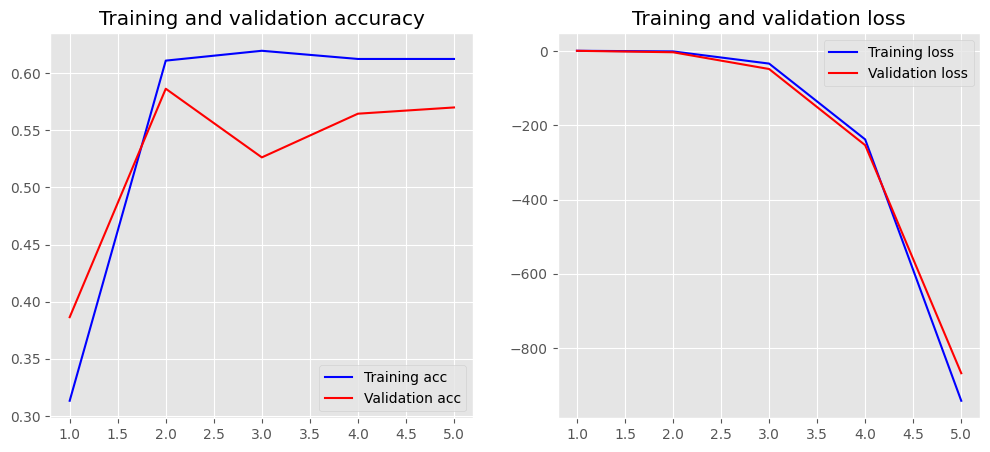

In [72]:
plot_history(history)
# history.history